In [ ]:
# import Libraries
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import rasterio
from lxml import etree
import numpy as np
from rasterio.warp import reproject, Resampling, calculate_default_transform
import geopandas as gpd
import os
from rasterio.features import rasterize
from shapely.geometry import box
from shapely.ops import unary_union

In [2]:
# extract geoinformation from a sample scene (.img file)
img_path = "./data2/RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip/sigma_s1r_amp_amp2e4_none_reproj.img"

with rasterio.open(img_path) as src:
    print("Width x Height:", src.width, "x", src.height)
    print("Number of bands:", src.count)
    print("Dtype:", src.dtypes)

    print("driver:", src.driver)
    print("CRS:", src.crs)
    print("Transform:", src.transform)
    print("Bounds:", src.bounds)

    print("Pixel spacing X:", src.transform.a)
    print("Pixel spacing Y:", -src.transform.e)

    for i in range(1, src.count + 1):
        print(f"Band {i} description:", src.descriptions[i-1])
        print(f"Band {i} tags:", src.tags(i))

    print(" GLOBAL TAGS", src.tags())

Width x Height: 18239 x 20475
Number of bands: 2
Dtype: ('uint16', 'uint16')
driver: HFA
CRS: PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",40],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",49],PARAMETER["standard_parallel_2",77],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Transform: | 20.00, 0.00, 362941.22|
| 0.00,-20.00, 2308769.11|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=362941.21848633944, bottom=1899269.1076785233, right=727721.2184863394, top=2308769.1076785233)
Pixel spacing X: 20.0
Pixel spacing Y: 20.0
Band 1 description: HH
Band 1 tags: {'LAYER_TYPE': 'athematic', 'STATISTICS_EXCLUDEDVALUES': '', 'STATISTICS_MAXIMUM': '31689', '

Load the data (HH, HV images from .img file & product.xml) & Extract Product ID, Geocoded info (lat/long), Pixel spacing

In [3]:
def load_all_rcm_products(data_dir):
    """
    RCM loader

    For each product folder:
        Finds SAR .img and product.xml
        Reads HH and HV bands
        Parses XML once
        Extracts:
            product_id
            pixel spacing
            all geocoded lat/lon points
    """

    data_dir = Path(data_dir)

    if not data_dir.is_dir():
        raise ValueError("data_dir must be a directory")

    dataset = []

    for product_dir in sorted(data_dir.iterdir()):
        if not product_dir.is_dir():
            continue

        try:
            # find files
            img_files = list(product_dir.rglob("*.img"))
            xml_files = list(product_dir.rglob("product.xml"))

            if len(img_files) != 1:
                raise ValueError("expected exactly one .img file")
            if not xml_files:
                raise FileNotFoundError("product.xml not found")

            img_path = img_files[0]

            # read HH & HV
            with rasterio.open(img_path) as src:
                if src.count != 2:
                    raise ValueError(f"expected 2 bands, found {src.count}")

                hh = src.read(1)
                hv = src.read(2)

            # parse product.xml
            xml_root = etree.parse(str(xml_files[0])).getroot()
            ns = {"rcm": xml_root.tag.split("}")[0].strip("{")}

            # metadata extraction

            # product ID
            product_id_elem = xml_root.find(".//rcm:productId", ns)
            product_id = (
                product_id_elem.text.strip() if product_id_elem is not None else None
            )

            # pixel spacing
            range_spacing_elem = xml_root.find(".//rcm:sampledPixelSpacing", ns)
            azimuth_spacing_elem = xml_root.find(".//rcm:sampledLineSpacing", ns)

            pixel_spacing = {
                "range_m": float(range_spacing_elem.text)
                if range_spacing_elem is not None else None,
                "azimuth_m": float(azimuth_spacing_elem.text)
                if azimuth_spacing_elem is not None else None,
            }

            # geocoded grid points (lon/lat)
            geocoded_points = []
            geodetic_coords = xml_root.findall(".//rcm:geodeticCoordinate", ns)

            for coord in geodetic_coords:
                lat = coord.find("rcm:latitude", ns)
                lon = coord.find("rcm:longitude", ns)

                if lat is not None and lon is not None:
                    geocoded_points.append({
                        "latitude": float(lat.text),
                        "longitude": float(lon.text)
                    })

            
            #  output
            dataset.append({
                "folder_name": product_dir.name,
                "product_id": product_id,
                "hh": hh,
                "hv": hv,
                "pixel_spacing": pixel_spacing,
                "geocoded_points": geocoded_points,
                "xml": xml_root
            })

        except Exception as e:
            print(f"Skipping {product_dir.name}: {e}")

    return dataset


In [4]:
# Test the loader function
data_dir = "./data2"
rcm_data = load_all_rcm_products(data_dir)

for p in rcm_data:
    print("=" * 60)
    print("File name      :", p["folder_name"])
    print("Product ID     :", p["product_id"])
    print("HH shape       :", p["hh"].shape)
    print("HV shape       :", p["hv"].shape)
    print("Pixel spacing  :", p["pixel_spacing"])

    print("First 5 geocoded points:")
    for pt in p["geocoded_points"][:5]:
        print(f"lat={pt['latitude']}, lon={pt['longitude']}")
    break

File name      : RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
Product ID     : 1188497_2
HH shape       : (20475, 18239)
HV shape       : (20475, 18239)
Pixel spacing  : {'range_m': 20.0, 'azimuth_m': 20.0}
First 5 geocoded points:
lat=60.57982843770729, lon=-92.93818333403263
lat=60.54318604055006, lon=-92.39204788346551
lat=60.50431813419547, lon=-91.84718225856555
lat=60.4632335359961, lon=-91.3036561888817
lat=60.41994152041963, lon=-90.7615382156817


Using sample: RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip


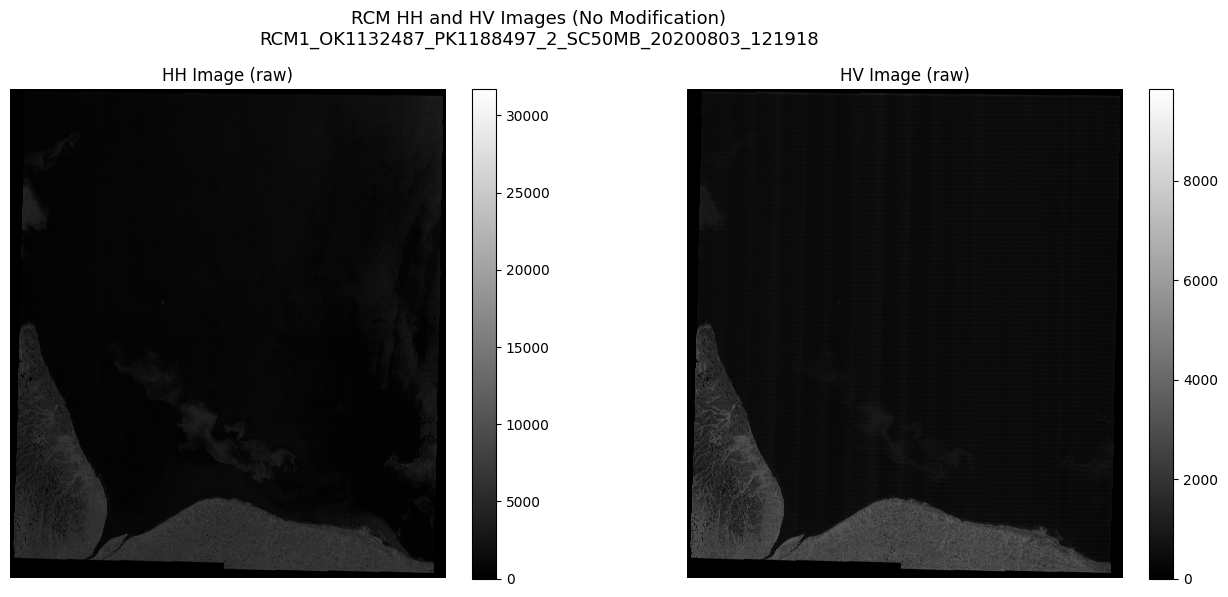

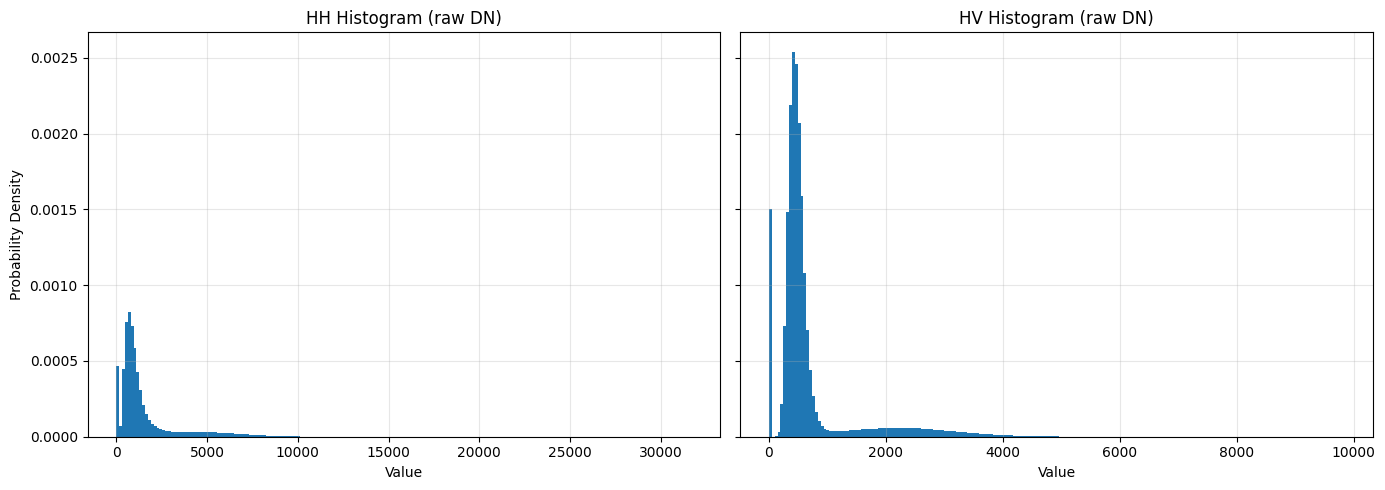

In [5]:
# plot HH, HV images & Histograms for 1 sample scene => RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
dataset = load_all_rcm_products("./data2")
print("Using sample:", dataset[0]["folder_name"])

hh = dataset[0]["hh"]
hv = dataset[0]["hv"]

# Plot HH & HV images =====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im0 = axs[0].imshow(hh, cmap="gray")
axs[0].set_title("HH Image (raw)")
axs[0].axis("off")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(hv, cmap="gray")
axs[1].set_title("HV Image (raw)")
axs[1].axis("off")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.suptitle(
    "RCM HH and HV Images (No Modification)\n"
    "RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918",
    fontsize=13
)
plt.tight_layout()
plt.show()

# Plot HH & HV histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].hist(hh.ravel(), bins=200, density=True)
axs[0].set_title("HH Histogram (raw DN)")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Probability Density")
axs[0].grid(alpha=0.3)

axs[1].hist(hv.ravel(), bins=200, density=True)
axs[1].set_title("HV Histogram (raw DN)")
axs[1].set_xlabel("Value")
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


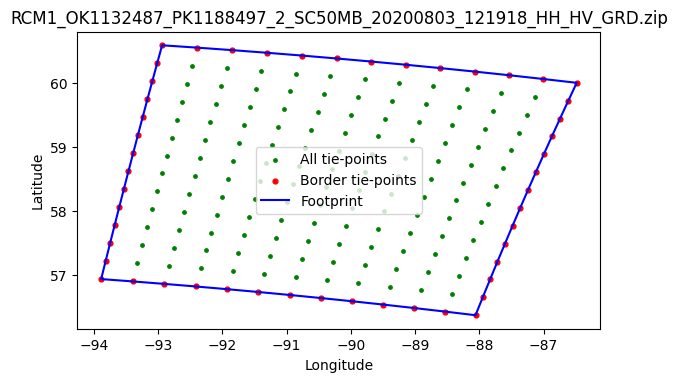

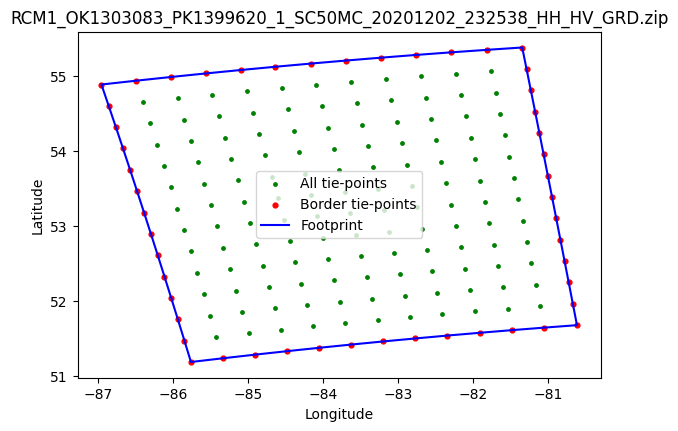

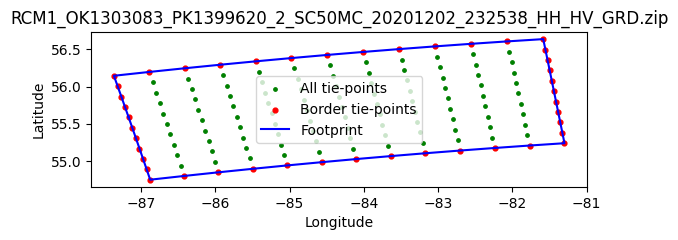

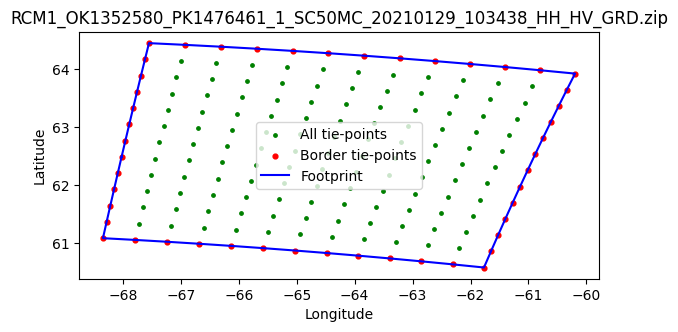

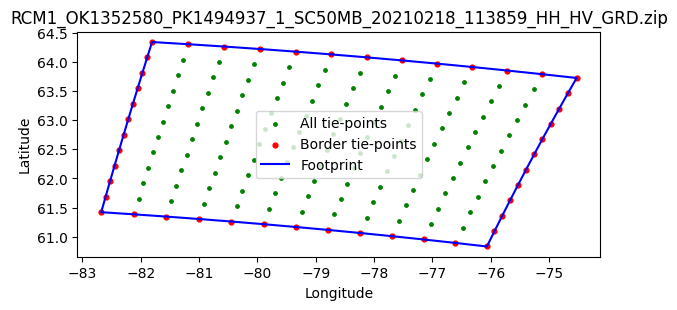

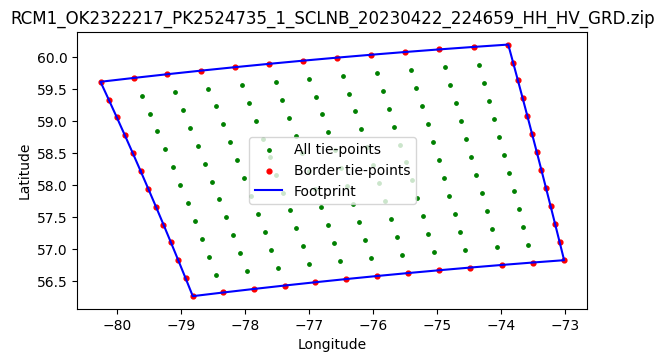

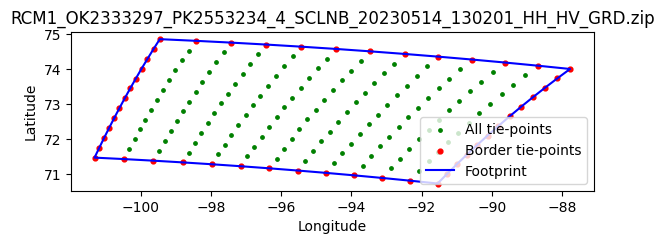

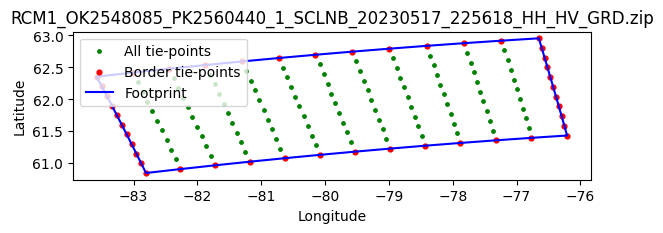

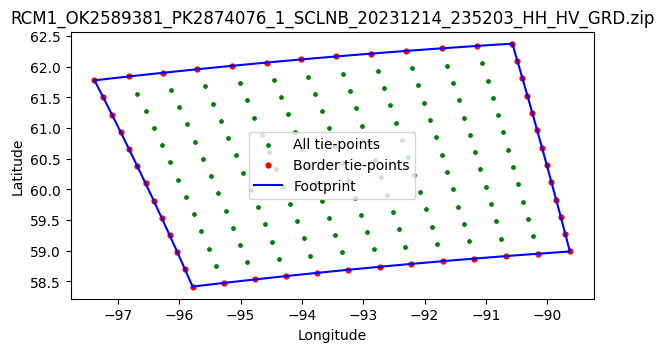

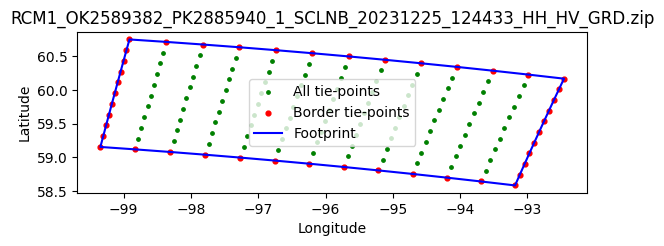

In [6]:
# plot all grid points

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Plot tie-points & footprints 
for item in dataset:
    xml_root = item["xml"]
    name = item["folder_name"]

    # namespace
    ns = {"ns": xml_root.tag.split('}')[0].strip('{')}

    # find tie-points
    tie_pts = xml_root.findall(".//ns:geolocationGrid/ns:imageTiePoint", namespaces=ns)

    if len(tie_pts) == 0:
        print(f"Skipping {name}: no tie-points found")
        continue

    lines, pixels, lats, lons = [], [], [], []

    for tp in tie_pts:
        img = tp.find("ns:imageCoordinate", namespaces=ns)
        geo = tp.find("ns:geodeticCoordinate", namespaces=ns)

        lines.append(float(img.find("ns:line", namespaces=ns).text))
        pixels.append(float(img.find("ns:pixel", namespaces=ns).text))
        lats.append(float(geo.find("ns:latitude", namespaces=ns).text))
        lons.append(float(geo.find("ns:longitude", namespaces=ns).text))

    # identify border tie-points
    min_line, max_line = min(lines), max(lines)
    min_pix,  max_pix  = min(pixels), max(pixels)

    border_mask = [
        (ln in (min_line, max_line) or px in (min_pix, max_pix))
        for ln, px in zip(lines, pixels)
    ]

    border_pts = [
        (lon, lat) for lon, lat, is_b in zip(lons, lats, border_mask) if is_b
    ]

    if len(border_pts) < 3:
        print(f"Skipping {name}: insufficient border points")
        continue

    # sort border points counter-clockwise
    cx = np.mean([p[0] for p in border_pts])
    cy = np.mean([p[1] for p in border_pts])
    border_pts_sorted = sorted(
        border_pts,
        key=lambda p: np.arctan2(p[1] - cy, p[0] - cx)
    )

    footprint = Polygon(border_pts_sorted)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(lons, lats, s=6, c="green", label="All tie-points")
    plt.scatter(*zip(*border_pts), s=12, c="red", label="Border tie-points")

    x, y = footprint.exterior.xy
    plt.plot(x, y, color="blue", linewidth=1.5, label="Footprint")

    plt.gca().set_aspect("equal", "box")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(name)
    plt.legend()
    plt.tight_layout()
    plt.show()

Scale HH and HV channels to 200m pixel spacing

In [7]:
def scale_hh_hv_to_200m(data_dir, target_spacing_m=200):
    """
    Loop over all RCM product folders in data_dir, rescale HH/HV to 200 m,
    and save the rescaled .img next to the original .img.
    """

    data_dir = Path(data_dir)

    for product_dir in sorted(data_dir.iterdir()):
        if not product_dir.is_dir():
            continue

        try:
            # find original .img
            img_files = list(product_dir.rglob("*.img"))
            if len(img_files) != 1:
                print(f"Skipping {product_dir.name}: expected 1 .img, found {len(img_files)}")
                continue

            img_path = img_files[0]

            with rasterio.open(img_path) as src:
                hh = src.read(1)
                hv = src.read(2)
                src_transform = src.transform
                src_crs = src.crs
                src_bounds = src.bounds

            # compute destination transform and shape
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src_crs,
                src_crs,
                hh.shape[1],
                hh.shape[0],
                *src_bounds,
                resolution=target_spacing_m
            )

            # allocate outputs
            hh_200m = np.empty((dst_height, dst_width), dtype=np.float32)
            hv_200m = np.empty((dst_height, dst_width), dtype=np.float32)

            # resample HH
            reproject(
                source=hh,
                destination=hh_200m,
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=src_crs,
                resampling=Resampling.bilinear
            )

            # resample HV
            reproject(
                source=hv,
                destination=hv_200m,
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=src_crs,
                resampling=Resampling.bilinear
            )

            # create output folder inside product_dir
            out_dir = product_dir / "200m_pixel_spacing"
            out_dir.mkdir(exist_ok=True)
            out_path = out_dir / (img_path.stem + "_200m.img")

            # save unified .img
            with rasterio.open(
                out_path,
                "w",
                driver="HFA",
                height=hh_200m.shape[0],
                width=hh_200m.shape[1],
                count=2,
                dtype=hh_200m.dtype,
                crs=src_crs,
                transform=dst_transform
            ) as dst:
                dst.write(hh_200m, 1)
                dst.write(hv_200m, 2)
                dst.set_band_description(1, "HH")
                dst.set_band_description(2, "HV")
                
        except Exception as e:
            print(f"Failed {product_dir.name}: {e}")

scale_hh_hv_to_200m("./data2", target_spacing_m=200)


| 200.00, 0.00, 362941.22|
| 0.00,-200.00, 2308769.11|
| 0.00, 0.00, 1.00|
Pixel size: 200.0 200.0
Bands: 2
('HH', 'HV')


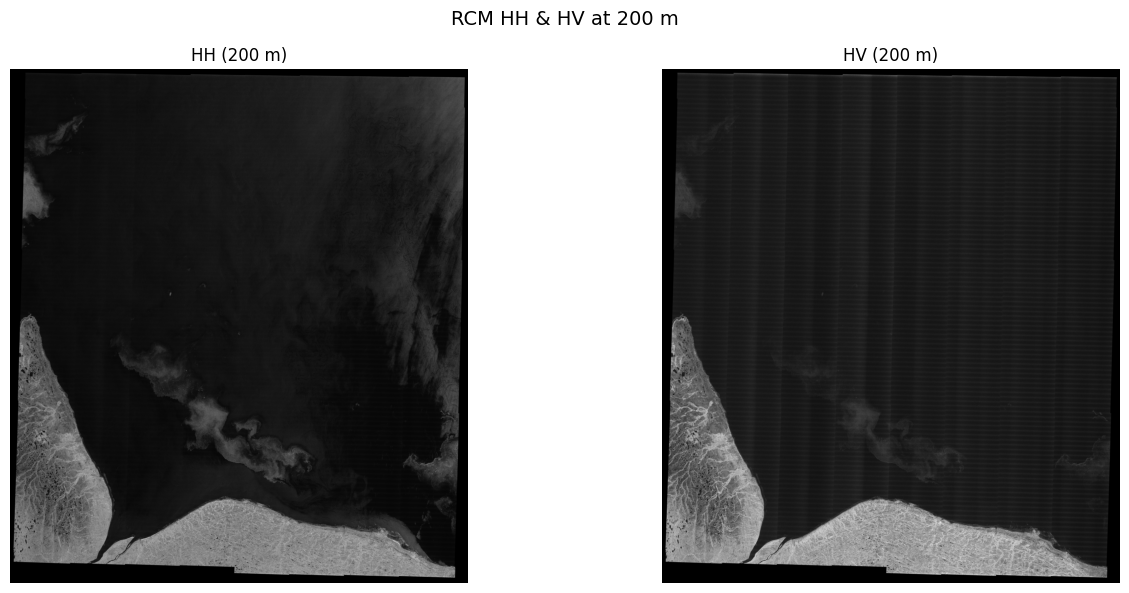

In [ ]:
# visualize rescaled images with 200m pixel spacing
img_200m_path = "./data2/RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip/200m_pixel_spacing/sigma_s1r_amp_amp2e4_none_reproj_200m.img"

with rasterio.open(img_200m_path) as src:
    print(src.transform)
    print("Pixel size:", src.transform.a, -src.transform.e)
    print("Bands:", src.count)
    print(src.descriptions)
    print("CRS:", src.crs)

with rasterio.open(img_200m_path) as src:
    hh_200m = src.read(1)
    hv_200m = src.read(2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(hh_200m, cmap="gray")
axs[0].set_title("HH (200 m)")
axs[0].axis("off")

axs[1].imshow(hv_200m, cmap="gray")
axs[1].set_title("HV (200 m)")
axs[1].axis("off")

plt.suptitle("RCM HH & HV at 200 m", fontsize=14)
plt.tight_layout()
plt.show()

Making the Land Mask

In [ ]:
def build_land_masks(shp_path: str, scenes: list[dict]) -> dict:
    """
      - The shapefile polygons represent OCEAN (ocean=1), so land is the inverse.
      - Returns boolean masks: True=land, False=other. dict: {product_id or folder_namee: land_mask_bool}
    """
    masks = {}

    # Read shapefile
    gdf_raw = gpd.read_file(shp_path)

    for i, scene in enumerate(scenes):
        # Read SAR grid info from the scene dict
        hh = scene["hh"]
        transform = scene["src_transform"]
        crs = scene["src_crs"]
        bounds = scene["src_bounds"]
        folder_name = scene["folder_name"]
        shape = hh.shape

        # Reproject shapefile to this scene CRS
        gdf = gdf_raw.to_crs(crs)

        # SAR bbox polygon
        sar_bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

        # Keep only shapefile features that intersect the SAR bbox + Clip the shapefile geometry to the SAR bbox 
        gdf = gdf[gdf.intersects(sar_bbox)].copy()
        gdf["geometry"] = gdf.intersection(sar_bbox)
        if len(gdf) == 0:
            print(f"warning: {folder_name}: shapefile does not intersect bbox")
            continue

        # Merge polygons
        geom = unary_union([g for g in gdf.geometry if g is not None and not g.is_empty])

        # Rasterize ocean polygons to mask
        ocean_mask = rasterize(
            [(geom, 1)],
            out_shape=shape,
            transform=transform,
            fill=0,
            dtype=np.uint8,
            all_touched=True,
        ).astype(bool)

        # Convert ocean-mask to land-mask (land=True, ocean=False)
        land_mask = ~ocean_mask
        masks[folder_name] = land_mask

    return masks

Returned type: <class 'dict'> | entries: 2
data2\RCM1_OK2589382_PK2885940_1_SCLNB_20231225_124433_HH_HV_GRD.zip\200m_pixel_spacing: shape=(1075, 1848), land_fraction=0.6985
data2\RCM1_OK2589381_PK2874076_1_SCLNB_20231214_235203_HH_HV_GRD.zip\200m_pixel_spacing: shape=(2279, 2218), land_fraction=0.4101


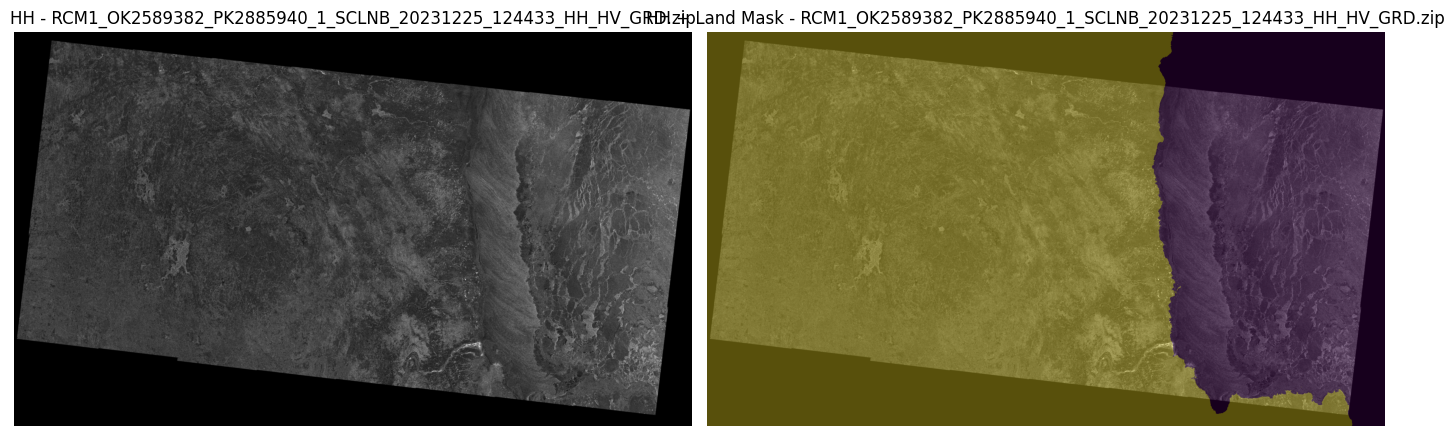

Saved: ./land_masks\RCM1_OK2589382_PK2885940_1_SCLNB_20231225_124433_HH_HV_GRD.zip_land_mask.tif


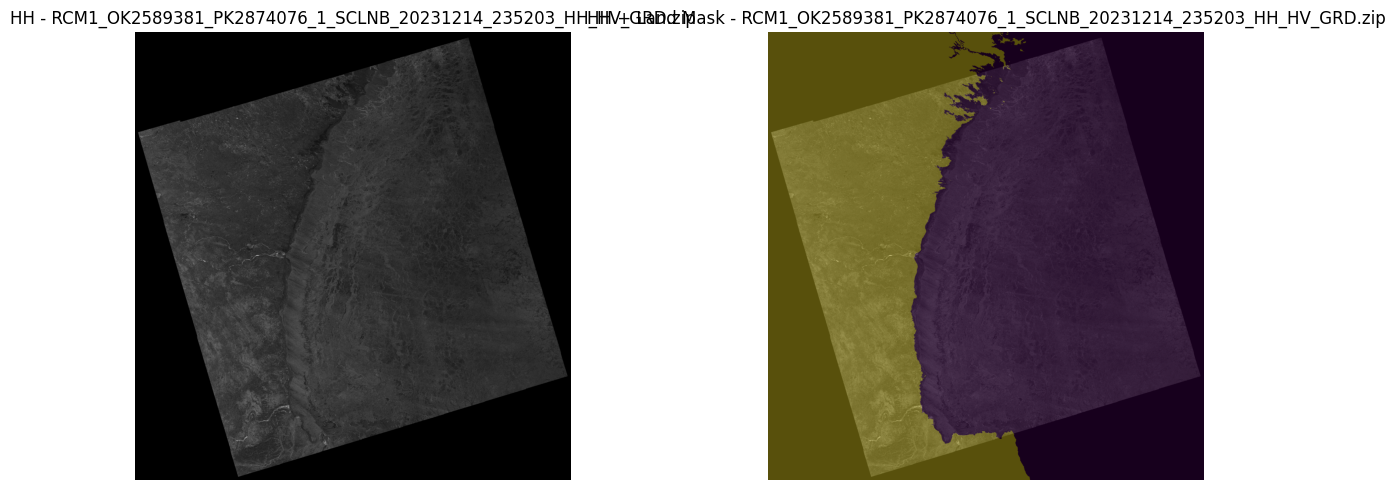

Saved: ./land_masks\RCM1_OK2589381_PK2874076_1_SCLNB_20231214_235203_HH_HV_GRD.zip_land_mask.tif


In [ ]:
img_paths = [
    r"./data2/RCM1_OK2589382_PK2885940_1_SCLNB_20231225_124433_HH_HV_GRD.zip/200m_pixel_spacing/sigma_s1r_amp_amp2e4_none_reproj_200m.img",
    r"./data2/RCM1_OK2589381_PK2874076_1_SCLNB_20231214_235203_HH_HV_GRD.zip/200m_pixel_spacing/sigma_s1r_amp_amp2e4_none_reproj_200m.img",
]
shp_path = r"./StatCan_ocean/StatCan_ocean.shp"
out_dir = r"./land_masks"
os.makedirs(out_dir, exist_ok=True)

# build scenes
scenes = []
for p in img_paths:
    with rasterio.open(p) as src:
        scenes.append({
            "folder_name": str(Path(p).parent),
            "product_id": Path(p).parts[-3],
            "hh": src.read(1),
            "src_transform": src.transform,
            "src_crs": src.crs,
            "src_bounds": src.bounds,
        })

masks = build_land_masks(shp_path, scenes)

print("Returned type:", type(masks), "| entries:", len(masks))
for k, m in masks.items():
    print(f"{k}: shape={m.shape}, land_fraction={float(m.mean()):.4f}")

# visualize + save
for s in scenes:
    folder = s["folder_name"]
    pid = s["product_id"]
    if folder not in masks:
        print(f"warning: {folder} not in masks")
        continue

    hh = s["hh"]
    land = masks[folder]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1); plt.title(f"HH - {pid}"); plt.imshow(hh, cmap="gray"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.title(f"HH + Land Mask - {pid}"); plt.imshow(hh, cmap="gray"); plt.imshow(land, alpha=0.35); plt.axis("off")
    plt.tight_layout(); plt.show()

    out_path = os.path.join(out_dir, f"{pid}_land_mask.tif")
    with rasterio.open(
        out_path, "w", driver="GTiff",
        height=land.shape[0], width=land.shape[1], count=1,
        dtype=rasterio.uint8, crs=s["src_crs"], transform=s["src_transform"],
        nodata=0, compress="lzw",
    ) as dst:
        dst.write(land.astype(np.uint8), 1)

    print("Saved:", out_path)
